In [268]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import matplotlib.pyplot as plt
import seaborn as sns
# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [2]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [3]:
########################### Vars
#################################################################################
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
# lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1941               # End day of our train set
START_VALID = 1913
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = False               # Use or not pretrained models

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
ORIGINAL = 'data/m5-forecasting-accuracy/'
BASE     = 'data/m5-original-simple-fe/grid_part_1.pkl'
PRICE    = 'data/m5-original-simple-fe/grid_part_2.pkl'
CALENDAR = 'data/m5-original-simple-fe/grid_part_3.pkl'
LAGS     = 'data/m5-lags-features/original.pkl'
MEAN_ENC = 'data/m5-custom-features/mean_encoding_df.pkl'


# AUX(pretrained) Models paths
AUX_MODELS = 'data/m5-aux-models/'


#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_evaluation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

In [4]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 
    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test
# -------------------------------------
def get_base_valid():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('valid_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test
# -------------------------------------

########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [5]:
grid_df, features = get_data_by_store('CA_1')

In [6]:
duplicated_features =  ['d','event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w',
             'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end']
sum_features = ['d', 'sales', 'sales_lag_28', 'sales_lag_29',
               'sales_lag_30', 'sales_lag_31', 'sales_lag_32', 'sales_lag_33',
               'sales_lag_34', 'sales_lag_35', 'sales_lag_36', 'sales_lag_37',
               'sales_lag_38', 'sales_lag_39', 'sales_lag_40', 'sales_lag_41',
               'sales_lag_42']

In [300]:
# START_TRAIN = 42                  # We can skip some rows (Nans/faster training)
# END_TRAIN   = 1941               # End day of our train set
# START_VALID = 1913
# P_HORIZON   = 28                 # Prediction horizon

START_TRAIN = 42                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
# START_VALID = 1885
START_VALID = 1800
P_HORIZON   = 28                 # Prediction horizon
END_TEST = 1941

In [301]:
X1 = grid_df[sum_features].groupby('d').agg('sum')
X2 = grid_df[duplicated_features].drop_duplicates().set_index('d')
X2 = X2.drop(columns=['snap_TX','snap_WI'])
# X1 = X1.drop(index=[331,697,1062,1427,1792])
# X2 = X2.drop(index=[331,697,1062,1427,1792])

train_X1 = X1.iloc[START_TRAIN:START_VALID+27].copy()
train_X2 = X2.iloc[START_TRAIN:START_VALID+27].copy()

valid_X1 = X1.iloc[START_VALID:END_TRAIN].copy()
valid_X2 = X2.iloc[START_VALID:END_TRAIN].copy()

test_X1 = X1.iloc[END_TRAIN-27:END_TEST].copy()
test_X2 = X2.iloc[END_TRAIN-27:END_TEST].copy()

train_X1 = train_X1.drop(index=[331,697,1062,1427,1792])
train_X2 = train_X2.drop(index=[331,697,1062,1427,1792])

In [252]:
# train_X1 = np.log1p(train_X1)
# valid_X1 = np.log1p(valid_X1)
# test_X1 = np.log1p(test_X1)

In [271]:
target_mean = train_X1['sales'].mean()
target_std = train_X1['sales'].std()
feature_mean = pd.concat([train_X1,valid_X1]).drop(columns='sales').astype(float).mean()
feature_std = pd.concat([train_X1,valid_X1]).drop(columns='sales').astype(float).std()

In [272]:
train_X1['sales'] = (train_X1['sales'] - target_mean) / target_std
train_X1.iloc[:,1:] = (train_X1.iloc[:,1:] - feature_mean) / feature_std

valid_X1['sales'] = (valid_X1['sales'] - target_mean) / target_std
valid_X1.iloc[:,1:] = (valid_X1.iloc[:,1:] - feature_mean) / feature_std

test_X1['sales'] = (test_X1['sales'] - target_mean) / target_std
test_X1.iloc[:,1:] = (test_X1.iloc[:,1:] - feature_mean) / feature_std

In [273]:
train_X1 = train_X1.astype(float)
valid_X1 = valid_X1.astype(float)
test_X1 = test_X1.astype(float)

In [274]:
# event_name_dict_1 = {}
# for event_name_1 in X2['event_name_1'].unique():
#     event_name_dict_1[event_name_1] = len(event_name_dict_1)
# event_name_dict_2 = {}
# for event_name_2 in X2['event_name_2'].unique():
#     event_name_dict_2[event_name_2] = len(event_name_dict_2)
# event_type_dict_1 = {}
# for event_type_1 in X2['event_type_1'].unique():
#     event_type_dict_1[event_type_1] = len(event_type_dict_1)
# event_type_dict_2 = {}
# for event_type_2 in X2['event_type_2'].unique():
#     event_type_dict_2[event_type_2] = len(event_type_dict_2)


In [275]:
# X2['event_name_1'] = X2['event_name_1'].map(event_name_dict_1)
# X2['event_name_2'] = X2['event_name_2'].map(event_name_dict_2)
# X2['event_type_1'] = X2['event_type_1'].map(event_type_dict_1)
# X2['event_type_2'] = X2['event_type_2'].map(event_type_dict_2)

## Model

In [276]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [277]:
class ContiniousDataset(Dataset):
    def __init__(self, df):
        self.y = df['sales'].values
        self.X = df.drop(columns='sales').values
    def __len__(self):
        return(len(self.y))
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]
    
class RNNDataset(Dataset):
    def __init__(self, df, test=False):
        self.test = test
        if not test:
            self.y = df['sales'].values
        self.X = df.drop(columns='sales').values
    def __len__(self):
        return(len(self.X)-27)
    def __getitem__(self,idx):
        if not self.test:
            return self.X[idx:idx+28], self.y[idx+27]
        return self.X[idx:idx+28]

In [278]:
# train_dataset = ContiniousDataset(train_X1)
# train_loader = DataLoader(train_dataset, batch_size=5)
# valid_dataset = ContiniousDataset(valid_X1)
# valid_loader = DataLoader(valid_dataset, batch_size=5)

train_dataset = RNNDataset(train_X1)
train_loader = DataLoader(train_dataset, batch_size=5)
valid_dataset = RNNDataset(valid_X1)
valid_loader = DataLoader(valid_dataset, batch_size=28)
test_dataset = RNNDataset(test_X1,True)
test_loader = DataLoader(test_dataset, batch_size=5)


In [279]:
class TotalSaleModel(nn.Module):
    def __init__(self):
        super().__init__()
#         self.event_name_1_emb = nn.Embedding(len(event_name_dict_1),5,padding_idx=0)
#         self.event_name_2_emb = nn.Embedding(len(event_name_dict_2),5,padding_idx=0)
#         self.event_type_1_emb = nn.Embedding(len(event_name_dict_1),3,padding_idx=0)
#         self.event_name_2_emb = nn.Embedding(len(event_name_dict_2),3,padding_idx=0)
#         self.event_name_2_emb = nn.Embedding(len(event_name_dict_2),3,padding_idx=0)
        self.linear_1 = nn.Linear(15, 64)
        self.linear_2 = nn.Linear(64, 128)
        self.linear_3 = nn.Linear(128, 32)
        self.linear_4 = nn.Linear(32, 1)
    def forward(self,x):
        x = self.linear_1(x)
        x = nn.ReLU()(x)
        x = self.linear_2(x)
        x = nn.ReLU()(x)
        x = self.linear_3(x)
        x = nn.ReLU()(x)
        x = self.linear_4(x)
        return x
    
class TotalSaleRNNModel(nn.Module):
    def __init__(self):
        super().__init__()
#         self.event_name_1_emb = nn.Embedding(len(event_name_dict_1),5,padding_idx=0)
#         self.event_name_2_emb = nn.Embedding(len(event_name_dict_2),5,padding_idx=0)
#         self.event_type_1_emb = nn.Embedding(len(event_name_dict_1),3,padding_idx=0)
#         self.event_name_2_emb = nn.Embedding(len(event_name_dict_2),3,padding_idx=0)
#         self.event_name_2_emb = nn.Embedding(len(event_name_dict_2),3,padding_idx=0)
#         self.linear_1 = nn.Linear(15, 64)
        self.lstm = nn.LSTM(15,32,num_layers=2,batch_first=True)
#         self.linear_2 = nn.Linear(64, 128)
#         self.linear_3 = nn.Linear(128, 32)
        self.linear_3 = nn.Linear(32, 16)
        self.linear_4 = nn.Linear(16, 1)
    def forward(self,x):
        x,_ = self.lstm(x)
#         print(x.shape)
        x = x[:,-1,:]
#         print(x.shape)
#         x = nn.Dropout(0.15)(x)
        x = self.linear_3(x)
#         print(x.shape)
        x = nn.ReLU()(x)
        x = self.linear_4(x)
#         x = nn.ReLU()(x)
#         x = self.linear_3(x)
#         x = nn.ReLU()(x)
#         x = self.linear_4(x)
        return x

In [280]:
# model = TotalSaleModel()
device = torch.device('cuda:1')
model = TotalSaleRNNModel().to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.0001,weight_decay=0.001)

In [281]:
epochs = 30
for epoch in range(epochs):
    total_loss = 0
    print('epoch: ', epoch)
    model.train()
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x = x.float().to(device)
        y = y.float().to(device)
        pred = model(x)
        loss = nn.MSELoss()(pred, y)
#         if i%20 == 0:
#             print(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('train loss: ', total_loss/len(train_loader))
    
    total_valid_loss = 0
    model.eval()
    for i, (x, y) in enumerate(valid_loader):
        x = x.float().to(device)
        y = y.float().to(device)
        with torch.no_grad():
            pred = model(x)
#         print(pred)
#         print(y)
        loss = nn.MSELoss()(pred, y)
#         if i%20 == 0:
#             print(loss.item())
        total_valid_loss += loss.item()
    print('valid loss: ', total_valid_loss/len(valid_loader))

epoch:  0
train loss:  0.9758421417930697
valid loss:  1.6674275398254395
epoch:  1
train loss:  0.8884144985140898
valid loss:  1.3049587309360504
epoch:  2
train loss:  0.8236401903302412
valid loss:  1.2620389312505722
epoch:  3
train loss:  0.7945658358774463
valid loss:  1.2545394748449326
epoch:  4
train loss:  0.7859959124648503
valid loss:  1.2492908388376236
epoch:  5
train loss:  0.7801643210354439
valid loss:  1.2440074384212494
epoch:  6
train loss:  0.7750881024320581
valid loss:  1.2385317385196686
epoch:  7
train loss:  0.7705187966564188
valid loss:  1.2327175289392471
epoch:  8
train loss:  0.7663227794771521
valid loss:  1.2269491255283356
epoch:  9
train loss:  0.7622955942054165
valid loss:  1.219775214791298
epoch:  10
train loss:  0.7584984591045016
valid loss:  1.2117848247289658
epoch:  11
train loss:  0.7549344225019811
valid loss:  1.2033531963825226
epoch:  12
train loss:  0.7515295989323206
valid loss:  1.193847730755806
epoch:  13
train loss:  0.74840542635

In [294]:
x, y = next(iter(train_loader))

In [295]:
pred = model(x.float().to(device)).reshape(-1).detach().cpu()

In [296]:
y*target_std+target_mean

tensor([3294., 4083., 4194., 3015., 2512.])

In [297]:
pred*target_std+target_mean

tensor([3373.6968, 3441.1624, 3448.6284, 3369.6265, 3296.3057])

In [292]:
x,y = next(iter(valid_loader))
pred = model(x.float().to(device)).reshape(-1).detach().cpu()

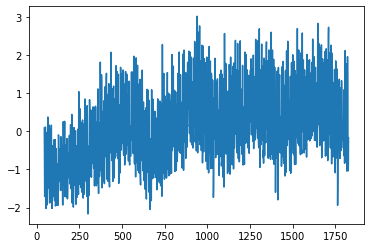

In [286]:
plt.plot(train_X1['sales'])

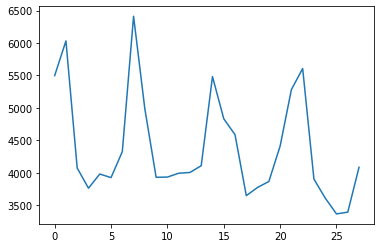

In [291]:
plt.plot(y*target_std+target_mean)

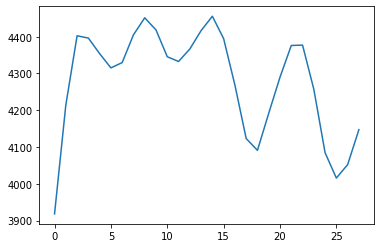

In [293]:
plt.plot(pred*target_std+target_mean)

## TS Model

In [327]:
import pmdarima as pm

In [331]:
total_sales = pd.read_csv('data/m5-forecasting-accuracy/sales_train_evaluation.csv').iloc[:,6:].sum()

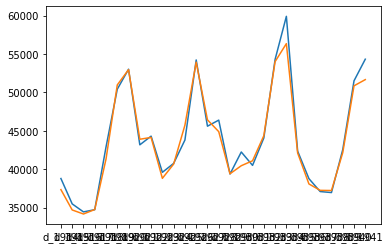

In [338]:
plt.plot(total_sales[-28:])
plt.plot(np.array([37346.97952521, 34697.056567  , 34169.37282507, 34752.16488117,
       41322.65187344, 50985.58638139, 52975.73610856, 43908.22184974,
       44146.90739217, 38818.16236656, 40674.04928053, 45739.76724214,
       53948.51689994, 46437.11313966, 44899.70881531, 39409.98352797,
       40461.68936154, 41104.44196123, 44371.39571685, 54020.21036345,
       56365.66285707, 42117.58159902, 38086.54974224, 37250.78425265,
       37231.75942256, 42152.83212667, 50869.81500775, 51677.46493856]))